Import necessary libraries

In [174]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from numpy import mean, std
import matplotlib.pyplot as plt


Import all data

In [179]:
seasons = range(2010,2023)
premier_match_data = {}
premier_team_data = {}
premier_player_data = {}
championship_match_data = {}
all_match_data = {}

for i in seasons:
    match_data_file = f'..//data//england_premier_match//england-premier-league-matches-{i}-to-{i+1}-stats.csv'
    team_data_file = f'..//data//england_premier_team//england-premier-league-teams-{i}-to-{i+1}-stats.csv'
    player_data_file = f'..//data//england_premier_player//england-premier-league-players-{i}-to-{i+1}-stats.csv'
    championship_match_data_file =  f'..//data//england_championship_match//england-championship-matches-{i}-to-{i+1}-stats.csv'

    premier_match_data[f'{i}_{i+1}'] = pd.read_csv(match_data_file)
    premier_team_data[f'{i}_{i+1}'] = pd.read_csv(team_data_file)
    premier_player_data[f'{i}_{i+1}'] = pd.read_csv(player_data_file)
    championship_match_data[f'{i}_{i+1}'] = pd.read_csv(championship_match_data_file)
    all_match_data[f'{i}_{i+1}'] = pd.concat([premier_match_data[f'{i}_{i+1}'], championship_match_data[f'{i}_{i+1}']], ignore_index=True)


Pre processing data
1. fill all missing value with -1 
2. Split goal scoring minutes into first half and second half
3. label encoding all object column
4. group previous three matches as the feature to train model.

In [151]:
def bin_goal_timings(goal_timings):
    # Parse the string into a list of integers
    if not isinstance(goal_timings, str):
        return (0,0)  # Return (0,0) if goal_timings is not a string

    if goal_timings=='-1':
        return (0,0)
    # Split the string into a list of times
    goal_times = goal_timings.split(',')

    first_half_goals = 0
    second_half_goals = 0

    for time in goal_times:
        # Check if it's stoppage time
        if "'" in time:
            time_parts = time.split("'")
            # Consider stoppage time as part of the second half
            if int(time_parts[0]) >= 45:
                second_half_goals += 1
        else:
            # Check if the goal was scored in the first or second half
            if int(time) <= 45:
                first_half_goals += 1
            else:
                second_half_goals += 1
    return first_half_goals, second_half_goals


In [180]:
# Create a list of all team names across all seasons
all_teams = []
all_referee = []
all_stadiums = []
for season in all_match_data.keys():
    all_teams.extend(list(all_match_data[season]['home_team_name'].unique()))
    
    all_referee.extend(list(all_match_data[season]['referee'].unique()))
  
    all_stadiums.extend(list(all_match_data[season]['stadium_name'].unique()))


    

In [182]:
le = LabelEncoder()
le_teams = LabelEncoder()
le_referee = LabelEncoder()
le_stadium = LabelEncoder()

le_teams.fit(all_teams)
le_referee.fit(all_referee)
le_stadium.fit(all_stadiums)


avoid_column = ['home_team_name','away_team_name','referee','stadium_name']
for season, df in all_match_data.items():

    # Transform teams
    df['home_team_name'] = le_teams.transform(df['home_team_name'])
    df['away_team_name'] = le_teams.transform(df['away_team_name'])
    df['referee'] = le_referee.transform(df['referee'])
    df['stadium_name'] = le_stadium.transform(df['stadium_name'])

    all_match_data[season] = df.fillna(-1,inplace=True)
   
    # Convert the column to string type
    for col in df.columns:
        
        if df[col].dtype == 'object' and col not in avoid_column:
            # Convert the column to string type
            df[col] = df[col].astype(str)
            
            # Apply the label encoder
            le.fit(df[col])
            df[col] = le.transform(df[col])

    
    all_match_data[season] = df
    

Now we need to group previous 3 game stats as features of this game

In [183]:
def calculate_rolling_stats(group):
    # List of columns to skip
    columns_to_skip = ['timestamp', 'date_GMT', 'status', 'home_team_name', 'away_team_name', 'referee', 'Game Week']
    group = group.sort_values('Game Week')
    # Iterate over all columns in the group
    for col in group.columns:
        # Skip the column if it is in the list of columns to skip
        if col not in columns_to_skip:
            # The rolling window size is 3, which means the previous 3 games
            group['rolling_avg_' + col] = group[col].rolling(window=3).mean()

    # Shift the data down 1 so the current game's stats aren't included
    group = group.shift(1)

    # Drop the first two rows (which won't have any rolling data)
    group = group.iloc[3:]
    
    return group


Get all rolling data and remove those without. 
Leave the 2022-23 as a test dataset.

In [184]:
# Initialize empty dictionaries to hold the stats for all seasons
all_seasons_home_stats = {}
all_seasons_away_stats = {}

# Get a list of all season keys, sorted in ascending order
seasons = sorted(all_match_data.keys())

# Use all seasons except the last one
for season in seasons[:-1]:
    # Apply the calculate_rolling_stats function to the home and away data for this season
    all_seasons_home_stats[season] = all_match_data[season].groupby('home_team_name').apply(calculate_rolling_stats)
    all_seasons_away_stats[season] = all_match_data[season].groupby('away_team_name').apply(calculate_rolling_stats)

# Convert the dictionaries to dataframes
all_seasons_home_stats_df = pd.concat(all_seasons_home_stats, keys=all_seasons_home_stats.keys())
all_seasons_away_stats_df = pd.concat(all_seasons_away_stats, keys=all_seasons_away_stats.keys())

# Now, the last season's data can be accessed separately like this
last_season_home_stats = all_match_data[seasons[-1]].groupby('home_team_name').apply(calculate_rolling_stats)
last_season_away_stats = all_match_data[seasons[-1]].groupby('away_team_name').apply(calculate_rolling_stats)


In [185]:
all_seasons_home_stats_df.to_csv("2022-23.csv", index=False)

Train

In [186]:
home_goals = all_seasons_home_stats_df['home_team_goal_count']
away_goals = all_seasons_away_stats_df['away_team_goal_count']

columns_to_drop_home = ['home_team_goal_count','total_goal_count','total_goals_at_half_time','home_team_goal_count_half_time','away_team_goal_count_half_time','home_team_goal_timings'
                   ,'away_team_goal_timings','home_team_corner_count','away_team_corner_count','home_team_yellow_cards','home_team_red_cards','away_team_yellow_cards','away_team_red_cards',
                   'home_team_first_half_cards','home_team_second_half_cards','away_team_first_half_cards','away_team_second_half_cards','home_team_shots','away_team_shots','home_team_shots_on_target',
                   'away_team_shots_on_target','home_team_shots_off_target','away_team_shots_off_target','home_team_fouls','away_team_fouls','home_team_possession','away_team_possession',
                   'status','attendance']

columns_to_drop_away = ['away_team_goal_count','total_goal_count','total_goals_at_half_time','home_team_goal_count_half_time','away_team_goal_count_half_time','home_team_goal_timings'
                   ,'away_team_goal_timings','home_team_corner_count','away_team_corner_count','home_team_yellow_cards','home_team_red_cards','away_team_yellow_cards','away_team_red_cards',
                   'home_team_first_half_cards','home_team_second_half_cards','away_team_first_half_cards','away_team_second_half_cards','home_team_shots','away_team_shots','home_team_shots_on_target',
                   'away_team_shots_on_target','home_team_shots_off_target','away_team_shots_off_target','home_team_fouls','away_team_fouls','home_team_possession','away_team_possession',
                   'status','attendance']

# Drop these columns from the predictor variables DataFrame
y_home = all_seasons_home_stats_df['home_team_goal_count']
y_away = all_seasons_away_stats_df['away_team_goal_count']
X_home = all_seasons_home_stats_df.drop(columns_to_drop_home, axis=1)
X_away = all_seasons_away_stats_df.drop(columns_to_drop_away, axis=1)


In [187]:
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(),
    "Gradient Boosting": GradientBoostingRegressor(),
    "Support Vector Regression": SVR()
}

In [190]:

def fit_and_compute_mse(models, X, y, k=10):
    mse_scores = {}
    for name, model in models.items():
        scores = cross_val_score(model, X, y, cv=k, scoring='neg_mean_squared_error')
        # Take the negative of the scores to get the MSE
        mse_scores[name] = -scores.mean()
        print(-scores.mean())
    # Plot
    plt.figure(figsize=(10, 5))
    plt.bar(mse_scores.keys(), mse_scores.values(), color='blue', alpha=0.6)
    plt.ylabel('Mean Squared Error')
    plt.title('Cross-validated MSE for different models')
    plt.show()



Home Goals:
0.8280156877294143
1.762111801242236
0.8475513664596275
0.7968326813461958
1.6758981301566078


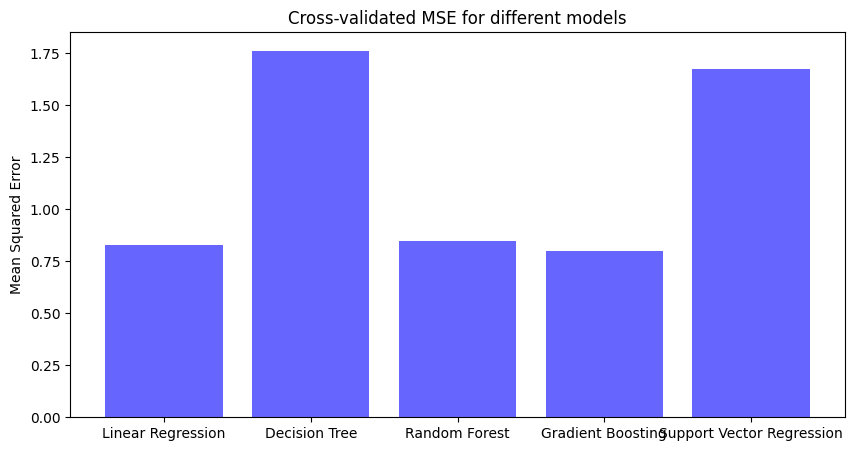

Away Goals:
0.6646784577602788
1.3968944099378882
0.7048501345755693
0.6614732955004082
1.2860122694552933


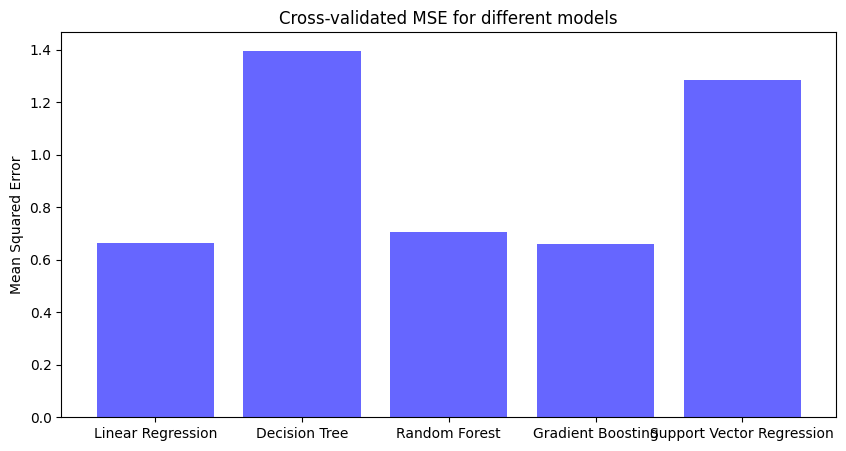

In [191]:
print("Home Goals:")
fit_and_compute_mse(models,X_home,y_home)

print("Away Goals:")
fit_and_compute_mse(models, X_away,y_away)